In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Indian_Extent = pd.read_excel(filepath, sheet_name='Indian-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Indian_Extent)
fp.date_time(Indian_Extent)

,Extent,Date
0,376618.799,1979-01-01
1,211788.726,1979-02-01
2,262868.141,1979-03-01
3,698377.304,1979-04-01
4,1252407.727,1979-05-01
...,...,...
533,1520776.003,2023-06-01
534,2076164.165,2023-07-01
535,2731799.027,2023-08-01
536,3179384.692,2023-09-01


In [5]:
scaler = MinMaxScaler()
Indian_Extent['Extent'] = scaler.fit_transform(Indian_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 9
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Indian_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((518, 12, 1), (518,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Indian_model_LT9/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 21s 259ms/step - loss: 0.2301 - root_mean_squared_error: 0.4797 - val_loss: 0.1517 - val_root_mean_squared_error: 0.3895
Epoch 2/50
53/53 [==============================] - 14s 272ms/step - loss: 0.1306 - root_mean_squared_error: 0.3614 - val_loss: 0.1062 - val_root_mean_squared_error: 0.3259
Epoch 3/50
53/53 [==============================] - 11s 219ms/step - loss: 0.1110 - root_mean_squared_error: 0.3332 - val_loss: 0.0923 - val_root_mean_squared_error: 0.3039
Epoch 4/50
53/53 [==============================] - 11s 219ms/step - loss: 0.0976 - root_mean_squared_error: 0.3125 - val_loss: 0.0748 - val_root_mean_squared_error: 0.2735
Epoch 5/50
53/53 [==============================] - 12s 221ms/step - loss: 0.0706 - root_mean_squared_error: 0.2656 - val_loss: 0.0406 - val_root_mean_squared_error: 0.2015
Epoch 6/50
53/53 [==============================] - 13s 256ms/step - loss: 0.0299 - root_mean_squared_error: 0.1730 - val_loss: 0.0172 

Epoch 35/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625
Epoch 36/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0053 - root_mean_squared_error: 0.0729 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0641
Epoch 37/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 38/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0054 - root_mean_squared_error: 0.0734 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721
Epoch 39/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0052 - root_mean_squared_error: 0.0721 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0704
Epoch 40/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0056 - root_mean_squared_error: 0.0746 - val_loss: 0.0062 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.431347926457723 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

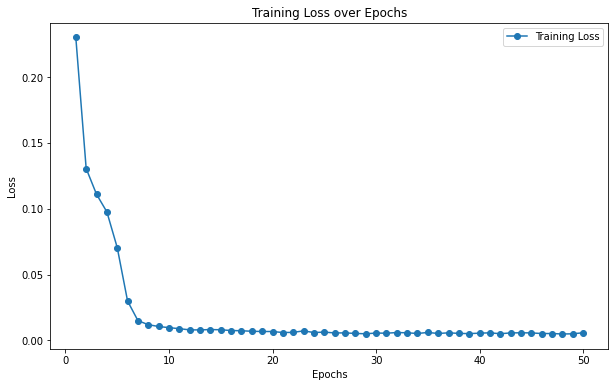

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

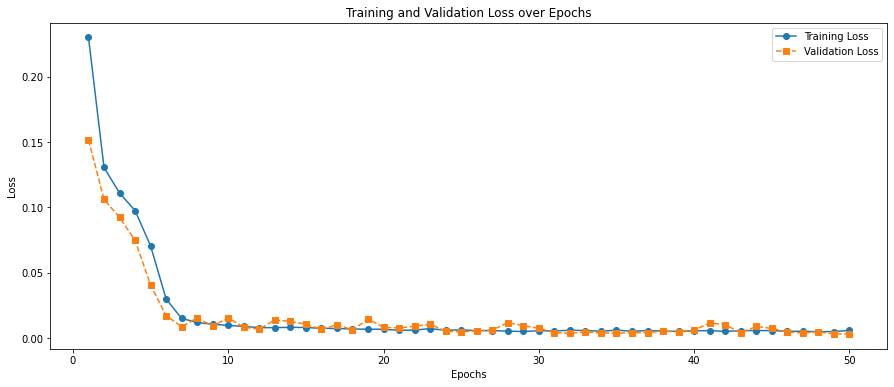

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Indian_model_LT9/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 17ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.04751248226686846
MAE : 0.03717763315418688


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,4.158473e+05,522831.371
1,2.247944e+05,346601.304
2,2.568121e+05,444914.605
3,5.331304e+05,827036.916
4,1.128083e+06,1142021.216
5,1.883284e+06,1885693.654
6,2.623329e+06,2542569.663
7,3.176885e+06,3107373.845
8,3.512080e+06,3488175.444
9,3.510016e+06,3746306.528


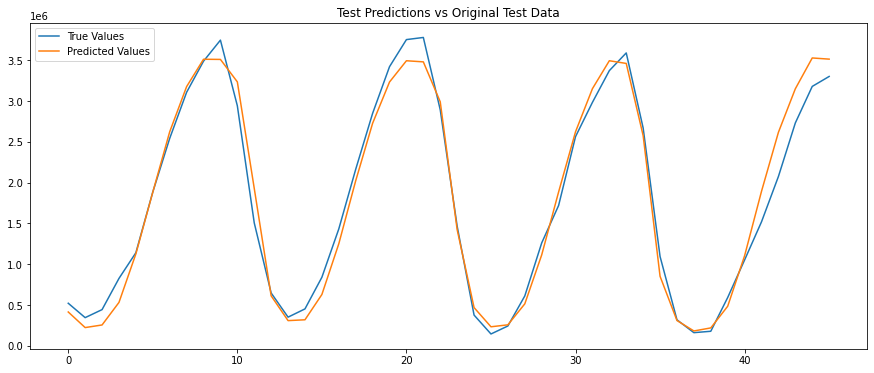

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 15ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

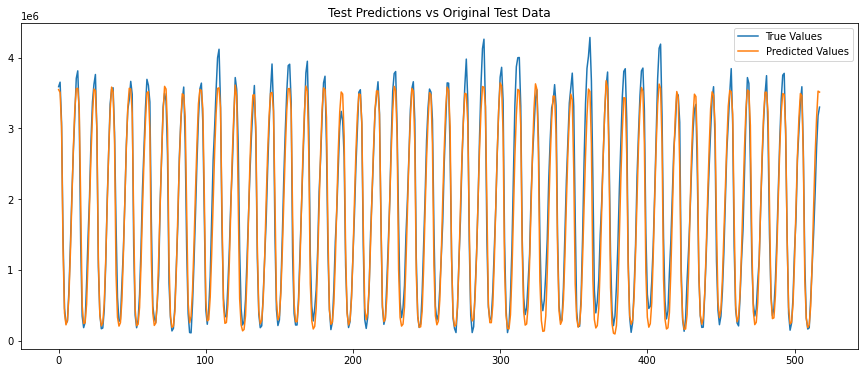

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()